In [1]:
include("speciale_tools.jl")
import JLD
import FileIO
import PyPlot

In [2]:

min_vv = -19
max_vv = 4

min_vh = -26
max_vh = -3

min_r = -10
max_r = 1;

min_h = -10
max_h = 100;



In [94]:
folder = "/home/data/simon/processed/177_jutlandS_winter2020/ribe" 

dem_nan = 40
co_gamma = JLD.load(joinpath(folder,"21VV_coher.jld"),"data")[end:-1:1,:]
pre_gamma = JLD.load(joinpath(folder,"23VV_coher.jld"),"data")[end:-1:1,:]

VV_paths = [joinpath(folder,string(i)*"VV_itens.jld") for i=1:3]
VV = [JLD.load(path,"data")[end:-1:1,:] for path in VV_paths]
VH_paths = [joinpath(folder,string(i)*"VH_itens.jld") for i=1:3]
VH = [JLD.load(path,"data")[end:-1:1,:] for path in VH_paths];
heights = JLD.load(joinpath(folder,"heights.jld"),"data")[end:-1:1,:].-dem_nan;

In [113]:
folder = "/home/data/simon/processed/66_fyn_winter2020/vejle" # desend

dem_nan = 40

co_gamma = JLD.load(joinpath(folder,"21VV_coher.jld"),"data")
pre_gamma = JLD.load(joinpath(folder,"23VV_coher.jld"),"data")

VV_paths = [joinpath(folder,string(i)*"VV_itens.jld") for i=1:3]
VV = [JLD.load(path,"data") for path in VV_paths]
VH_paths = [joinpath(folder,string(i)*"VH_itens.jld") for i=1:3]
VH = [JLD.load(path,"data") for path in VH_paths];
heights = JLD.load(joinpath(folder,"heights.jld"),"data").-dem_nan;

line_sample = JLD.load(joinpath(folder,"line_sample.jld"))
samples = collect(line_sample["samples"]) #[1:7:end]
lines = collect(line_sample["lines"]) #[1:2:end]
lut = JLD.load(joinpath(folder,"21_lut.jld"),"data");

In [114]:
#### 


filt = SlcUtil.temporal_filter([VV[1],VH[1]],5);

VV = SlcUtil.temporal_filter(VV,5);
VH = SlcUtil.temporal_filter(VH,5);

VV[1] = filt[1]
VH[1] = filt[2];

In [5]:
size(VV[1])

(812, 1711)

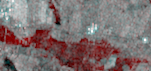

In [6]:
#test_area = (220:240,80:140) ; folder = "/home/data/simon/result/explore/area_1"
#test_area = (640:709,880:950) ; folder = "/home/data/simon/result/explore/area_2"
test_area = (550:620,1050:1200)
#test_area = (300:500,750:950)
pretty_img(VV,min_vv,max_vv)[test_area...]

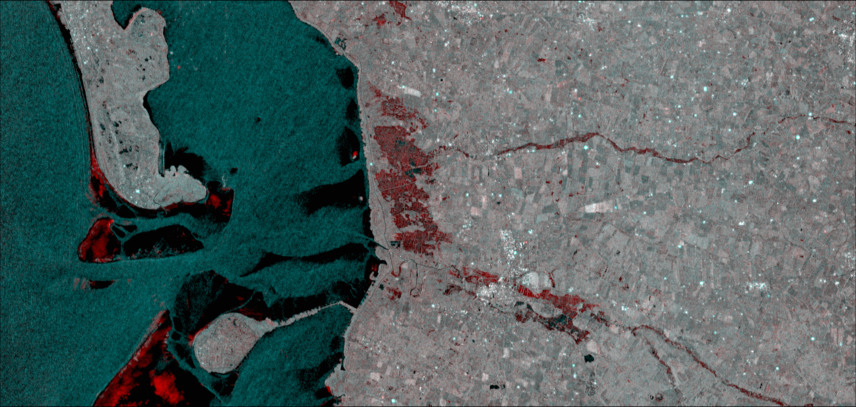

In [7]:
pretty_img(VV,min_vv,max_vv)

### Fit_bimodal

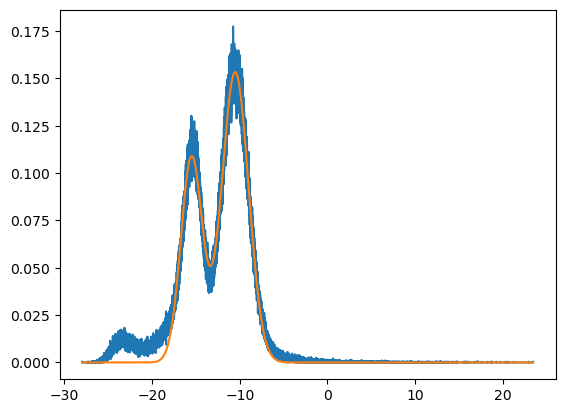

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb4dc2fb7c0>

In [8]:
data = 10 .* log10.(flat(VV[1],test_area));
data = 10 .* log10.(reshape(VV[1],:));
p_fit,y,w = fit_bimodal_gauss(data,round(Int64,length(data)/50),10000)

PyPlot.figure()
PyPlot.plot(y,w)
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )

## Check tile function

In [9]:
data = 10 .* log10.(flat(VH[1],test_area));
N = round(Int64,length(data)/50)
bimodal_tile(data,N)

true

In [14]:
N = round(Int64,length(data)/200)

6947

In [15]:
bimodal_tile(data,N)

(false, [3.5953634463926574, 0.9262933159520604, 0.5629231409128331])

In [10]:
data = 10 .* log10.(flat(VV[1],test_area));
N = round(Int64,length(data)/50)
bimodal_tile(data,N,conditions=(2,0.95,0.1))

true

In [16]:
bimodal_tile(data,N,conditions=(2,0.95,0.1))

(false, [3.5953634463926574, 0.9262933159520604, 0.5629231409128331])

In [25]:
min_N =10^3 
bin_size=50
conditions=(2,0.99,0.1)

data = 10 .* log10.(VV[1]);
dims = size(data)
N =  dims[1]*dims[2]
BM_mask = zeros(Bool,dims...)

n_bins = round(Int64,N/bin_size)
bm_tile, cons = bimodal_tile(reshape(data,:),n_bins,conditions=conditions) 





(false, [3.5953722628878584, 0.9258321750773469, 0.5629175156253278])

In [31]:
row_split = floor(Int64,dims[1]/2)
col_split = floor(Int64,dims[2]/2)

855

In [43]:
tile11 = data[1:row_split,1:col_split];
tile21 = data[(row_split+1):dims[1],1:col_split]
tile12 = data[1:row_split,(col_split+1):dims[2]]
tile22 = data[(row_split+1):dims[1],(col_split+1):dims[2]];

In [44]:
test = hcat(vcat(tile11,tile21),vcat(tile12,tile22));

In [107]:
function find__bimodal_tiles(data; N_limit = (10^3, 3*10^5), bin_size=50,conditions=(2,0.99,0.1))
    dims = size(data)
    N =  dims[1]*dims[2]
    BM_mask = zeros(Bool,dims...)
    
    #println("N: $N")
    ## Area to small
    if N < N_limit[1]
        #println("Limit reached")
        return BM_mask
    end
    
    bm_tile = false
    if N < N_limit[2]
        n_bins = round(Int64,N/bin_size)
        bm_tile, cons = bimodal_tile(reshape(data,:),n_bins,conditions=conditions) 
    end
    
    if bm_tile
        BM_mask .= true
    else
        row_split = floor(Int64,dims[1]/2)
        col_split = floor(Int64,dims[2]/2)
        
        tiles = [(1:row_split,1:col_split),((row_split+1):dims[1],1:col_split),
            (1:row_split,(col_split+1):dims[2]),((row_split+1):dims[1],(col_split+1):dims[2])]
        
        for elem in tiles
            BM_mask[elem...] .= find__bimodal_tiles(data[elem...], 
                N_limit =N_limit, bin_size=bin_size,conditions=conditions)
        end
        
    end
    
    return BM_mask
end
    

find__bimodal_tiles (generic function with 4 methods)

### Ribe test

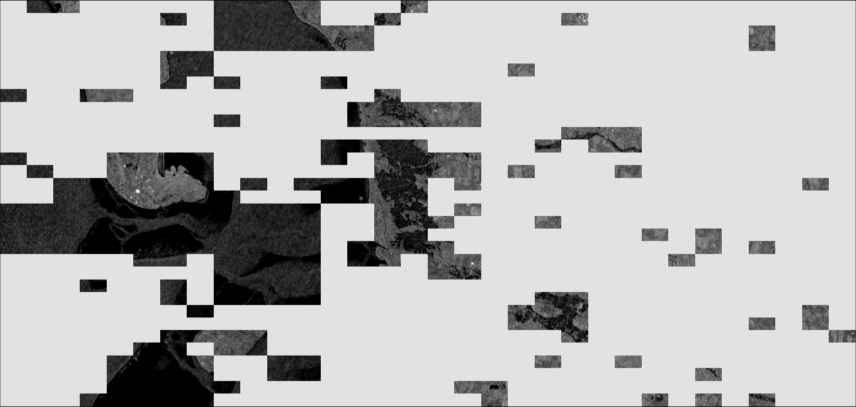

In [108]:

bm_mask_test = find__bimodal_tiles(10 .*log10.(VV[1]));
img = Colors.Gray.(db_scale_img(VV[1],min_vv,max_vv));
img = add_mask(img, (bm_mask_test .!=true) ,(1,1,0))

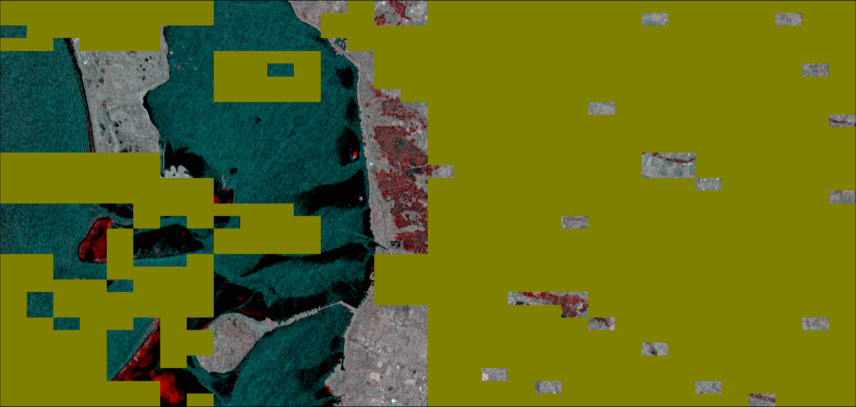

In [109]:
change_VV = 10 .*log10.(VV[1]).- 10 .*log10.((VV[2] .+ VV[3])./2);
bm_mask_test = find__bimodal_tiles(change_VV);
img = pretty_img(VV,min_vv,max_vv);
img = add_mask(img, (bm_mask_test .!=true) ,(0.5,0.5,0))

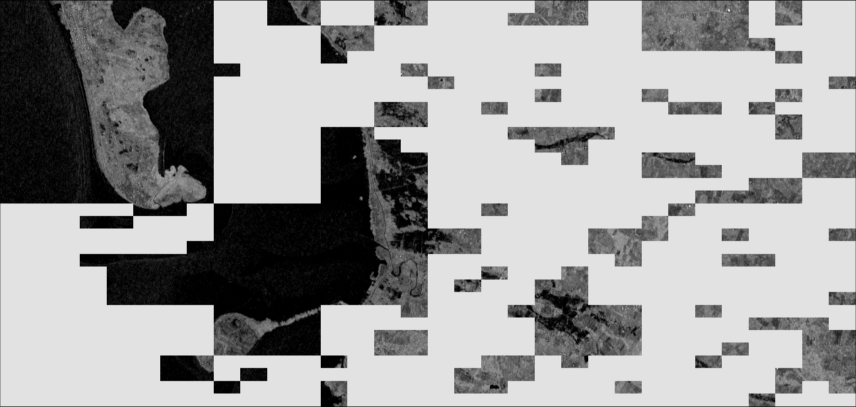

In [110]:
bm_mask_test = find__bimodal_tiles(10 .*log10.(VH[1]));
img = Colors.Gray.(db_scale_img(VH[1],min_vh,max_vh));
img = add_mask(img, (bm_mask_test .!=true) ,(1,1,0))

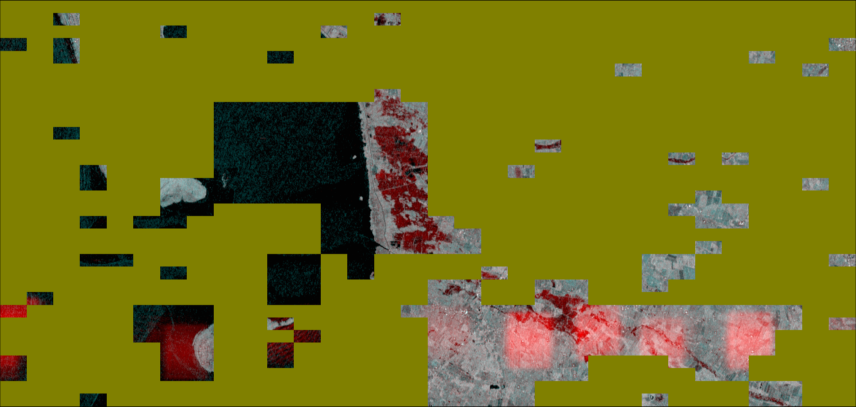

In [111]:
change_VH = 10 .*log10.(VH[1]).- 10 .*log10.((VH[2] .+ VH[3])./2);
bm_mask_test = find__bimodal_tiles(change_VH);
img = pretty_img(VH,min_vh,max_vh);
img = add_mask(img, (bm_mask_test .!=true) ,(0.5,0.5,0))

## Vejle test

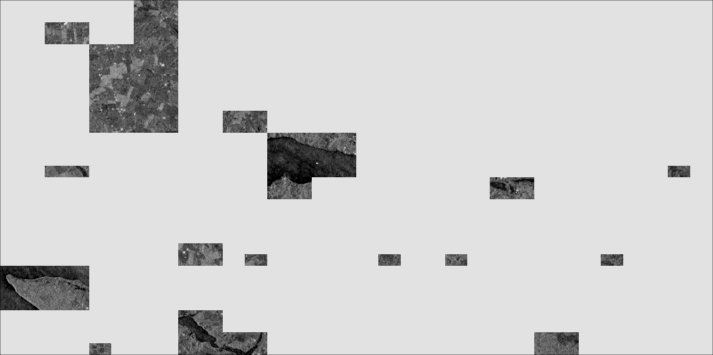

In [115]:
bm_mask_test = find__bimodal_tiles(10 .*log10.(VV[1]));
img = Colors.Gray.(db_scale_img(VV[1],min_vv,max_vv));
img = add_mask(img, (bm_mask_test .!=true) ,(1,1,0))

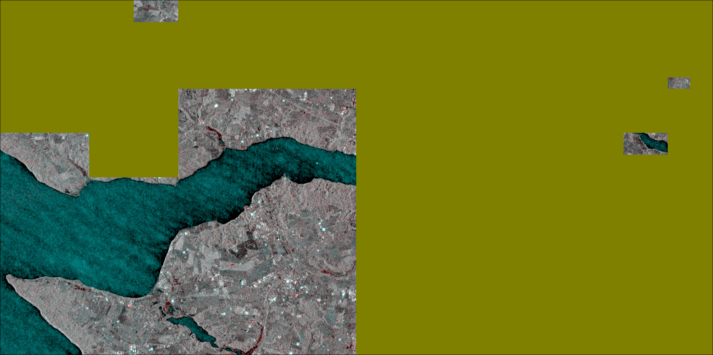

In [116]:
change_VV = 10 .*log10.(VV[1]).- 10 .*log10.((VV[2] .+ VV[3])./2);
bm_mask_test = find__bimodal_tiles(change_VV);
img = pretty_img(VV,min_vv,max_vv);
img = add_mask(img, (bm_mask_test .!=true) ,(0.5,0.5,0))

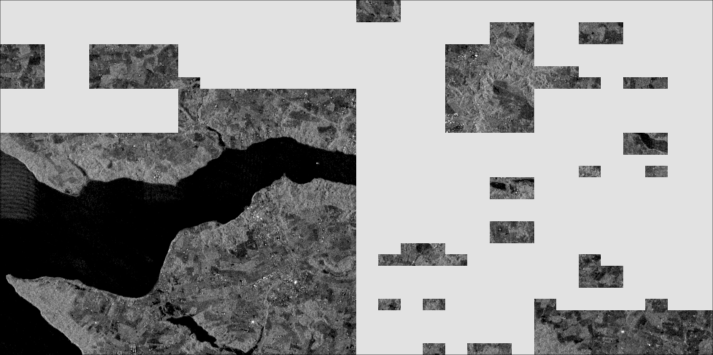

In [117]:
bm_mask_test = find__bimodal_tiles(10 .*log10.(VH[1]));
img = Colors.Gray.(db_scale_img(VH[1],min_vh,max_vh));
img = add_mask(img, (bm_mask_test .!=true) ,(1,1,0))

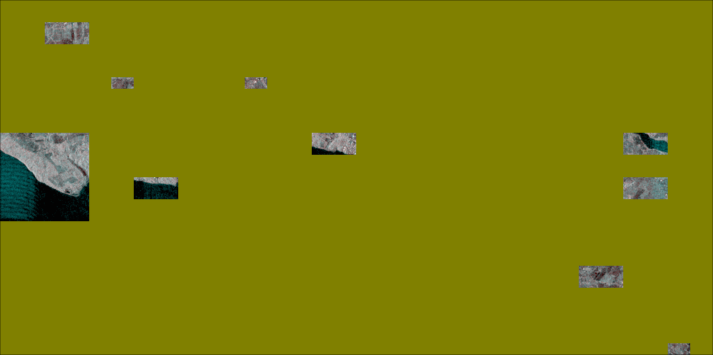

In [118]:
change_VH = 10 .*log10.(VH[1]).- 10 .*log10.((VH[2] .+ VH[3])./2);
bm_mask_test = find__bimodal_tiles(change_VH);
img = pretty_img(VH,min_vh,max_vh);
img = add_mask(img, (bm_mask_test .!=true) ,(0.5,0.5,0))